<div>
<img src="opencosmo_simple_transparent.png" width="600">
</div>

# OpenCosmo Tutorial - investigating massive haloes

The portal sometimes outputs linked data - this is, for example, when you run the haloproperties task and select that you'd like to output profiles as well. One type of linked data is the bighaloparticle data associated with massive halos. I'm going to start from the assumption that you've downloaded the particle data and have it saved on your machine as haloparticles.hdf5. 

Now we just open it as a linked file using 
```python
data = oc.open_linked_files(halopropertyfile, haloparticlefile)
```

and for now let's filter it so we get one halo at random at a cluster-range sod halo mass. 

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import opencosmo as oc

# here the sodproperties are the binned profiles, and the haloproperties are just the standard property file. 
# these are linked as you've requested them from the website at the same time. 
data = oc.open_linked_files("haloproperties.hdf5", "haloparticles.hdf5")

# cut here is in Msun - remember this is a factor of h different from the portal 
data = data.filter(oc.col("sod_halo_mass") > 2e14, oc.col("sod_halo_mass") < 1e16).take(1,at="random")


We now have the data, although we didn't select the specific properties we need as we're not sure what those are yet. If you do know which ones you want add 
```python
dataset.select([property1,property2])
```
to the last line. If filtering is entirely new to you, check the OpenCosmo toolkit documentation or the getting started tutorial. 

## Plotting particle data
Let's get started plotting this halo. We're going to select only the dark matter particles using the argument to the objects. Here every halo is a generator object (requires you to iterate over it) which is accessed as 
```python
halo_object, other_linked_object = iter(dataset.objects([type_if_applicable]))
```

Now let's get the positions, as well as the SOD halo radius and the center position, and make a quick scatter plot with the r200c radius overplotted. Fun fact, because this is random you'll get a new halo each time you run this notebook. 

<div class="alert alert-block alert-info"><b>Tip: </b> You might be wondering why we're using the fof halo center here, it's because the SOD halos are built out from the fof center so this is how they're defined. These correspond to minimum potential points for the FOF halo  </div> 


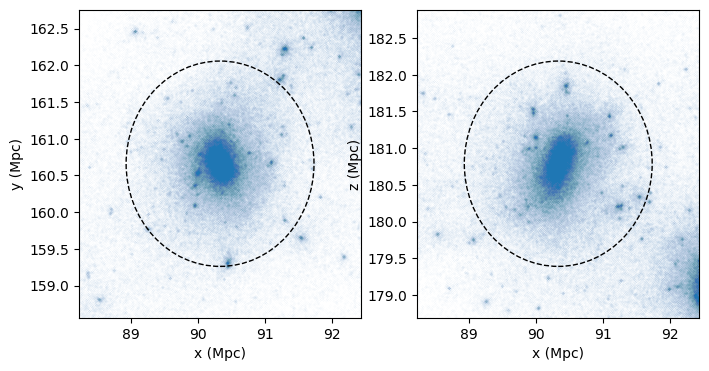

In [108]:
for halo_properties, halo_particles in data.objects(['dm_particles']):
    rad = halo_properties['sod_halo_radius'].value

    # note: why we're using fof values here
    center_x =  halo_properties['fof_halo_center_x'].value 
    center_y =  halo_properties['fof_halo_center_y'].value
    center_z =  halo_properties['fof_halo_center_z'].value

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].scatter(halo_particles.data['x'].data,halo_particles.data['y'].data,s=0.0001)
    circle = plt.Circle((center_x, center_y), rad, color='k', fill=False, linestyle='--')
    ax[0].add_patch(circle)
    ax[0].set_xlim([center_x-rad*1.5,center_x+rad*1.5])
    ax[0].set_ylim([center_y-rad*1.5,center_y+rad*1.5])
    ax[0].set_xlabel('x (Mpc)')
    ax[0].set_ylabel('y (Mpc)')

    ax[1].scatter(halo_particles.data['x'].data,halo_particles.data['z'].data,s=0.0001)
    circle = plt.Circle((center_x, center_z), rad, color='k', fill=False, linestyle='--')
    ax[1].add_patch(circle)
    ax[1].set_xlim([center_x-rad*1.5,center_x+rad*1.5])
    ax[1].set_ylim([center_z-rad*1.5,center_z+rad*1.5])
    ax[1].set_xlabel('x (Mpc)')
    ax[1].set_ylabel('z (Mpc)')


    plt.show()



You can make whatever measurements you like on this halo using this data, but you can also find more information from the portal..

## Halo profile 

To match different types of data, we typically use the fof halo tag. We can get this from the halo data first, then filter the profiles on this. 

Note that since I used an iterator over a single object, the halo_properties and halo_particles correspond to that object. Otherwise it would correspond to the last halo you looked at. If you have multiple halos you would ideally open the datasets ahead of time, and then filter them for the halo tag within the iterator, remembering not to overwrite the initial dataset. 

In [109]:
tag = halo_properties['fof_halo_tag']

data_profile = oc.open_linked_files("haloproperties.hdf5", "sodproperties.hdf5")

# cut here is in Msun - remember this is a factor of h different from the portal 
data_profile = data_profile.filter(oc.col("fof_halo_tag") == tag)


Now we're going to use our known particle mass and the volume of the bin to convert these to a density profile, and plot that against an NFW profile from CCL. 

Note that there are two inaccuracies in the way I've done this. First I'm missing the full mass profile in here so I'm just using the dark matter particles to compute the profile, and I'm using the concentration from a concentration-mass relation rather than the measured concentration. You should be able to fix both of these if you like and see if your NFW profiles look better than mine!

Note if you don't have CCL installed this is detailed in the getting started tutorial. 

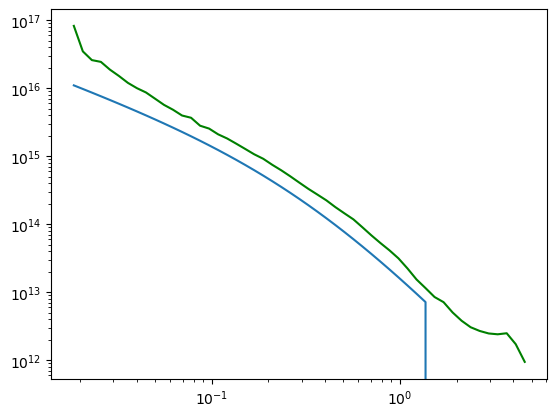

In [111]:
mpp = 1670703700.0
halo_prop, halo_profile = tuple(data_profile.objects())[0]
mass_halo = halo_prop['sod_halo_mass']

import pyccl as ccl
from pyccl.halos.profiles.nfw import HaloProfileNFW
mass_def = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=mass_def)
cosmo = ccl.Cosmology(Omega_c=0.26067, Omega_b=0.0489, h=0.6766, sigma8=0.8102, n_s=0.9665)
prof_ccl = HaloProfileNFW(mass_def = mass_def, concentration=cM)

# update to actual mass
edges = halo_profile.data['sod_halo_bin_radius'].data[0]
edges = np.insert(edges,0,0)
volume = 4./3.*(np.pi)* (edges[1:]**3-edges[:-1]**3)
# our measurement is too high because this includes gas particles
plt.plot(halo_profile.data['sod_halo_bin_radius'].data[0], halo_profile.data['sod_halo_bin_count'].data[0]*mpp/volume,'g')
plt.plot(halo_profile.data['sod_halo_bin_radius'].data[0], prof_ccl.real(cosmo,halo_profile.data['sod_halo_bin_radius'].data[0], mass_halo.value, 1.0))
plt.xscale('log')
plt.yscale('log')


## Challenges:
- Perform this on Frontier-E gravity only data
- Get the orientation data from the halos and make an ellipsoidal NFW profile
- See if you can get the NFW profile to fit properly!